# Training VGG11 on MNIST

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random
!pip install torchsummary
from torchsummary import summary

In [16]:
# The output of torchvision datasets are PILImage images of range [0,1].
# Transform them to Tensors of normalized range [-1, 1]

transform = transforms.Compose( #transforms 함수 미리 정의
    [transforms.Resize((32,32)),
     transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])
#위의 normalize는 는 image = (image - mean) / std 를 시켜줌. 3 개인 이유는 각 채널마다 mean, std를 적용시켜야 되기 때문. 
#input value [0,1] -> [-1, 1] range로 바뀜. 예를 들어서, minimum value 0은 (0-0.5)/0.5 = -1, maximum value 1은 (1-0.5)/0.5 = 1 이 된다.

batch_size = 8


### load MNIST dataset from torchvision

In [17]:
#load dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True, #torchvision의 dataset에서 CIFAR10 dataset다운 받음. 
                                      download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                      download=True, transform=transform)
#define dataloader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                         shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                        shuffle=False, num_workers=2)

classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

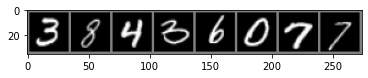

    3     8     4     3     6     0     7     7


In [18]:
# display some images

import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
    
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

### Define VGG11

In [19]:
class VGG(nn.Module):
    
    def __init__(self, num_classes=1000):
        super(VGG, self).__init__()
        self.conv1_1 = self.make_conv_relu(1, 64)
        
        self.conv2_1 = self.make_conv_relu(64, 128)

        self.conv3_1 = self.make_conv_relu(128, 256)
        self.conv3_2 = self.make_conv_relu(256, 256)

        self.conv4_1 = self.make_conv_relu(256, 512)
        self.conv4_2 = self.make_conv_relu(512, 512)

        self.conv5_1 = self.make_conv_relu(512, 512)
        self.conv5_2 = self.make_conv_relu(512, 512)
        
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.relu = nn.ReLU()
        
        self.classifier = nn.Linear(512, num_classes)

    def make_conv_relu(self, in_channels, out_channel):
        layers = []
        layers += [nn.Conv2d(in_channels, out_channel, kernel_size=3, padding=1),  #using kernel size 3, padding 1 -> keep the spatial dimension of tensor
                   nn.ReLU()]
        return nn.Sequential(*layers)
        
    def forward(self, x):
        # x shape: [Batchsize, 1, 32, 32]
        
        x = self.conv1_1(x) # [Batchsize, 64, 32, 32]
        x = self.maxpool(x) # [Batchsize, 64, 16, 16]
        
        x = self.conv2_1(x) # [Batchsize, 128, 16, 16]
        x = self.maxpool(x) # [Batchsize, 128, 8, 8]
        
        x = self.conv3_1(x) # [Batchsize, 256, 8, 8]
        x = self.conv3_2(x) # [Batchsize, 256, 8, 8]
        x = self.maxpool(x) # [Batchsize, 256, 4, 4]
        
        x = self.conv4_1(x) # [Batchsize, 512, 4, 4]
        x = self.conv4_2(x) # [Batchsize, 512, 4, 4]
        x = self.maxpool(x) # [Batchsize, 512, 2, 2]
        
        x = self.conv5_1(x) # [Batchsize, 512, 2, 2]
        x = self.conv5_2(x) # [Batchsize, 512, 2, 2]
        x = self.maxpool(x) # [Batchsize, 512, 1, 1]

        x = x.view(x.size(0), -1) # [Batchsize, 512]
        
        x = self.classifier(x) # [Batchsize, num_classes]
        
        return x

In [20]:
net = VGG(10)
net.train()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
net.to(device)

summary(net, batch_size=-1, input_size=(1, 32, 32), device='cuda')

cuda:0
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]             640
              ReLU-2           [-1, 64, 32, 32]               0
         MaxPool2d-3           [-1, 64, 16, 16]               0
            Conv2d-4          [-1, 128, 16, 16]          73,856
              ReLU-5          [-1, 128, 16, 16]               0
         MaxPool2d-6            [-1, 128, 8, 8]               0
            Conv2d-7            [-1, 256, 8, 8]         295,168
              ReLU-8            [-1, 256, 8, 8]               0
            Conv2d-9            [-1, 256, 8, 8]         590,080
             ReLU-10            [-1, 256, 8, 8]               0
        MaxPool2d-11            [-1, 256, 4, 4]               0
           Conv2d-12            [-1, 512, 4, 4]       1,180,160
             ReLU-13            [-1, 512, 4, 4]               0
           Conv2d-14            

### Define a Loss function and optimizer
* Use Classification Cross-Entropy loss
* Use Adam with learning rate 0.0001 

In [21]:
import torch.optim as optim

# define a loss and optimizer
criterion = nn.CrossEntropyLoss() #CrossEntropyLoss에 softmax까지 구현되어있기 때문에 모델에 softmax를 선언하지 않아도 됨. 
optimizer = optim.Adam(net.parameters(), lr=0.0001)

### Train the network on the training data

In [22]:
### Train the network
print('Start Training ')
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # Fill this loop
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        # print statistics
        if i % 500 == 499:
            print("epoch: {}, iter: {}, loss: {:.3f}".format(epoch+1, i+1, running_loss / 500))
            running_loss = 0.0

print('Finished Training')

Start Training 
epoch: 1, iter: 500, loss: 1.081
epoch: 1, iter: 1000, loss: 0.252
epoch: 1, iter: 1500, loss: 0.202
epoch: 1, iter: 2000, loss: 0.159
epoch: 1, iter: 2500, loss: 0.127
epoch: 1, iter: 3000, loss: 0.087
epoch: 1, iter: 3500, loss: 0.110
epoch: 1, iter: 4000, loss: 0.095
epoch: 1, iter: 4500, loss: 0.093
epoch: 1, iter: 5000, loss: 0.082
epoch: 1, iter: 5500, loss: 0.085
epoch: 1, iter: 6000, loss: 0.070
epoch: 1, iter: 6500, loss: 0.071
epoch: 1, iter: 7000, loss: 0.066
epoch: 1, iter: 7500, loss: 0.070
epoch: 2, iter: 500, loss: 0.043
epoch: 2, iter: 1000, loss: 0.061
epoch: 2, iter: 1500, loss: 0.066
epoch: 2, iter: 2000, loss: 0.047
epoch: 2, iter: 2500, loss: 0.058
epoch: 2, iter: 3000, loss: 0.057
epoch: 2, iter: 3500, loss: 0.046
epoch: 2, iter: 4000, loss: 0.045
epoch: 2, iter: 4500, loss: 0.055
epoch: 2, iter: 5000, loss: 0.051
epoch: 2, iter: 5500, loss: 0.044
epoch: 2, iter: 6000, loss: 0.045
epoch: 2, iter: 6500, loss: 0.052
epoch: 2, iter: 7000, loss: 0.052


### Test the network on the test data

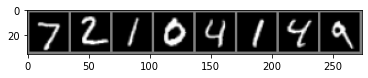

GrondTruth:      7     2     1     0     4     1     4     9


In [23]:
dataiter = iter(testloader)
images, labels = dataiter.next()
#print images
imshow(torchvision.utils.make_grid(images))
print('GrondTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))


In [24]:
images = images.cuda()
outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(batch_size))) 


Predicted:      7     2     1     0     4     1     4     9


In [25]:
# Let us look at how the network performs on the whole dataset

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 98 %


In [26]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()

        for i in range(batch_size):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of     0 : 99 %
Accuracy of     1 : 97 %
Accuracy of     2 : 99 %
Accuracy of     3 : 99 %
Accuracy of     4 : 95 %
Accuracy of     5 : 99 %
Accuracy of     6 : 98 %
Accuracy of     7 : 98 %
Accuracy of     8 : 99 %
Accuracy of     9 : 99 %
